## 1. 导入依赖与环境设置

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import copy

# 设置随机种子保证可复现
torch.manual_seed(42)
np.random.seed(42)

# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. 数据准备与分布式切分
这里我们将 MNIST 训练集随机打乱后均分给 10 个 Worker。

In [8]:
# 定义超参数
NUM_WORKERS = 10
NUM_BYZANTINE = 3  # 恶意节点数量 (满足 2f + 2 < n, 即 2*3+2=8 < 10)
BATCH_SIZE = 64

# 加载 MNIST 数据
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# 将数据索引切分给 10 个 Worker (IID 分布)
data_indices = np.arange(len(train_dataset))
np.random.shuffle(data_indices)
worker_indices = np.array_split(data_indices, NUM_WORKERS)

# 创建 DataLoader 列表
train_loaders = []
for idx_list in worker_indices:
    subset = torch.utils.data.Subset(train_dataset, idx_list)
    loader = torch.utils.data.DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)
    train_loaders.append(loader)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"数据准备完毕: {NUM_WORKERS} 个 Worker，其中 {NUM_BYZANTINE} 个是拜占庭节点。")

数据准备完毕: 10 个 Worker，其中 3 个是拜占庭节点。


## 3. 定义模型与辅助函数
我们需要将梯度“扁平化”成一个向量，以便 Krum 计算欧几里得距离。

In [9]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # 原论文是双隐层 MLP
        # 假设隐藏层维度为 128 (论文未指定具体维度，通常为 128-256)
        self.fc1 = nn.Linear(784, 128) # Input -> Hidden 1
        self.fc2 = nn.Linear(128, 128) # Hidden 1 -> Hidden 2
        self.fc3 = nn.Linear(128, 10)  # Hidden 2 -> Output

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)) # Activation 1
        x = F.relu(self.fc2(x)) # Activation 2
        x = self.fc3(x)         # Output
        return x

def get_flat_grad(model):
    """提取模型梯度并展平为一维向量"""
    grads = []
    for param in model.parameters():
        if param.grad is not None:
            grads.append(param.grad.view(-1))
    return torch.cat(grads)

def apply_flat_grad(model, flat_grad):
    """将一维梯度向量恢复并应用到模型参数的 .grad 属性中"""
    idx = 0
    for param in model.parameters():
        num_param = param.numel()
        if param.grad is not None:
            param.grad = flat_grad[idx : idx + num_param].view(param.shape)
        else:
            # 如果 grad 是 None，初始化它
            param.grad = flat_grad[idx : idx + num_param].view(param.shape).clone()
        idx += num_param

def get_flat_params(model):
    """提取模型参数并展平为一维向量"""
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))
    return torch.cat(params)

def load_flat_params(model, flat_params):
    """将一维参数向量恢复并加载到模型中"""
    idx = 0
    for param in model.parameters():
        num_param = param.numel()
        param.data = flat_params[idx : idx + num_param].view(param.shape).clone()
        idx += num_param

## 4. 核心：实现 Krum 算法
这是复现的核心部分。Krum 的逻辑是：对于每一个向量 $V_i$，计算它与最近的 $n-f-2$ 个邻居的距离平方和（Score），然后选择 Score 最小的那个向量。

In [10]:
def krum_aggregation(gradients, f):
    """
    Krum 聚合算法实现
    Args:
        gradients: list of tensors, 包含所有 worker 的梯度向量
        f: int, 拜占庭节点的数量
    Returns:
        Tensor, 被选中的梯度向量 (Best fit)
    """
    n = len(gradients)
    # Krum 参数: 选取最近的 n - f - 2 个邻居
    # 论文中定义 n >= 2f + 3 以保证容错性，但只要 n > 2f+2 即可运行
    num_neighbors = n - f - 2 
    
    # 距离矩阵
    distances = torch.zeros((n, n)).to(gradients[0].device)
    
    # 计算两两欧氏距离的平方 ||Vi - Vj||^2
    # 为了效率，这里使用简单的双重循环（对于 n=10 很快）
    for i in range(n):
        for j in range(i, n):
            d = torch.norm(gradients[i] - gradients[j]) ** 2
            distances[i, j] = d
            distances[j, i] = d
    
    # 计算得分
    scores = []
    for i in range(n):
        # 对距离进行排序
        dists_sorted, _ = torch.sort(distances[i])
        # 排除自身距离(0)，选取最近的 num_neighbors 个
        # sort 结果第一个是自身(0.0)，所以取 [1 : num_neighbors+1]
        # 注意：Krum 是选择与自己最近的邻居，不包括自己
        neighbor_dists = dists_sorted[1 : num_neighbors + 1]
        score = torch.sum(neighbor_dists)
        scores.append(score)
        
    # 选择得分最小的梯度的索引
    best_idx = torch.argmin(torch.tensor(scores))
    
    return gradients[best_idx]

def multi_krum_aggregation(gradients, f, m=None):
    """
    Multi-Krum 聚合算法实现
    Args:
        gradients: list of tensors, 包含所有 worker 的梯度向量
        f: int, 拜占庭节点的数量
        m: int, 选取的聚合向量数量。如果为 None，默认为 n - f
    Returns:
        Tensor, 聚合后的梯度向量
    """
    n = len(gradients)
    
    # 默认 m 取 n - f，即尝试保留所有诚实节点
    if m is None:
        m = n - f
        
    # Krum 的邻居数量参数 (n - f - 2)
    num_neighbors = n - f - 2 
    
    # --- 1. 计算距离 (与 Krum 相同) ---
    distances = torch.zeros((n, n)).to(gradients[0].device)
    for i in range(n):
        for j in range(i, n):
            d = torch.norm(gradients[i] - gradients[j]) ** 2
            distances[i, j] = d
            distances[j, i] = d
    
    # --- 2. 计算得分 (与 Krum 相同) ---
    scores = []
    for i in range(n):
        dists_sorted, _ = torch.sort(distances[i])
        # 排除自身(0)，取最近的 num_neighbors 个
        neighbor_dists = dists_sorted[1 : num_neighbors + 1]
        score = torch.sum(neighbor_dists)
        scores.append(score)
        
    # --- 3. 选择 Top-m (Multi-Krum 特有) ---
    # 将 scores 转换为 tensor
    scores_tensor = torch.tensor(scores)
    
    # 获取得分最低（最好）的 m 个索引
    # torch.topk 默认找最大，设置 largest=False 找最小
    values, indices = torch.topk(scores_tensor, k=m, largest=False)
    
    # --- 4. 计算平均值 ---
    selected_grads = [gradients[i] for i in indices]
    
    # 将选中的 m 个梯度堆叠并求平均
    aggregated_grad = torch.stack(selected_grads).mean(dim=0)
    
    return aggregated_grad

# 对比用的平均聚合
def average_aggregation(gradients):
    return torch.stack(gradients).mean(dim=0)

## 5. 模拟攻击与训练循环
我们模拟了 Omniscient 攻击（恶意节点将梯度乘以一个很大的负数例如 -100） 和 Gaussian 攻击（生成与 flat_grad 形状相同的随机高斯向量）

In [11]:
def train_distributed(aggregation_method, attack_type="Omniscient", num_epochs=5, f=3):
    model = MLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    history_loss = []
    history_acc = []
    
    print(f"开始训练: 聚合方法={aggregation_method}, 恶意节点数={f}")
    
    # 模拟迭代
    # 为了简化，我们只迭代一定数量的全局轮次，每轮每个 worker 只算一个 batch
    
    steps_per_epoch = len(train_loaders[0])
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        # 创建迭代器
        iterators = [iter(loader) for loader in train_loaders]
        
        for _ in range(steps_per_epoch):
            # 1. Server 广播参数 (此处省略，因为是串行模拟，直接用同一个model算梯度)
            
            collected_gradients = []
            
            # 2. 遍历每个 Worker 计算梯度
            for worker_id in range(NUM_WORKERS):
                try:
                    data, target = next(iterators[worker_id])
                except StopIteration:
                    # 如果数据耗尽，重置迭代器（简化处理）
                    iterators[worker_id] = iter(train_loaders[worker_id])
                    data, target = next(iterators[worker_id])
                
                data, target = data.to(device), target.to(device)
                
                # 清零梯度，计算前向后向
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                
                # 获取平铺的梯度
                flat_grad = get_flat_grad(model)
                
                # 3. 拜占庭攻击逻辑
                # 假设最后 f 个节点是恶意的
                if worker_id >= (NUM_WORKERS - f):
                    # 如果是恶意节点
                    if attack_type == "Omniscient":
                        # 1. 全知攻击：反向并放大
                        attacked_grad = flat_grad * -100.0
                        collected_gradients.append(attacked_grad)
                        
                    elif attack_type == "Gaussian":
                        # 2. 高斯攻击：生成随机噪声
                        # 论文中使用了较大的标准差 (如 200) 来测试鲁棒性
                        noise_mean = 0.0
                        noise_std = 200.0 
                        # 生成与 flat_grad 形状相同的随机高斯向量
                        gaussian_noise = torch.normal(mean=noise_mean, std=noise_std, size=flat_grad.shape).to(device)
                        collected_gradients.append(gaussian_noise)
                        
                else:
                    # 如果是诚实节点
                    collected_gradients.append(flat_grad)
            
            # 4. 参数服务器聚合
            if aggregation_method == "Avg":
                global_grad = average_aggregation(collected_gradients)
            elif aggregation_method == "Krum":
                global_grad = krum_aggregation(collected_gradients, f)
            elif aggregation_method == "Multi-Krum":
                # Multi-Krum: 这里我们取 m = n - f = 10 - 3 = 7
                global_grad = multi_krum_aggregation(collected_gradients, f, m=(NUM_WORKERS - f))
            
            # 5. 更新全局模型
            optimizer.zero_grad()
            apply_flat_grad(model, global_grad) # 将聚合后的梯度放回模型
            optimizer.step()
            
            epoch_loss += loss.item()
            
        # 6. 评估
        avg_loss = epoch_loss / steps_per_epoch
        history_loss.append(avg_loss)
        
        # 测试集准确率
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        acc = 100. * correct / len(test_loader.dataset)
        history_acc.append(acc)
        model.train()
        
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={acc:.2f}%")
        
    return history_loss, history_acc

# 计算一轮 epoch 后聚合
def train_distributed_standard(aggregation_method, attack_type="Omniscient", num_epochs=5, f=3):
    # 初始化全局模型
    global_model = MLP().to(device)
    criterion = nn.CrossEntropyLoss()
    
    history_loss = []
    history_acc = []
    
    print(f"开始标准训练 (Epoch-based): 聚合={aggregation_method}, 攻击={attack_type}")
    
    for epoch in range(num_epochs):
        # 1. 保存当前全局参数 (作为基准)
        global_params = get_flat_params(global_model)
        collected_updates = []
        total_loss = 0.0
        
        # 2. 遍历每个 Worker (模拟分布式并行训练)
        for worker_id in range(NUM_WORKERS):
            # --- Worker 本地训练开始 ---
            # 复制一份全局模型给 Worker
            local_model = copy.deepcopy(global_model)
            local_optimizer = optim.SGD(local_model.parameters(), lr=0.01)
            local_model.train()
            
            # 跑完本地所有数据 (一个完整的 Epoch)
            worker_loss = 0.0
            for data, target in train_loaders[worker_id]:
                data, target = data.to(device), target.to(device)
                local_optimizer.zero_grad()
                output = local_model(data)
                loss = criterion(output, target)
                loss.backward()
                local_optimizer.step()
                worker_loss += loss.item()
            
            total_loss += worker_loss / len(train_loaders[worker_id]) # 记录平均 loss
            
            # 计算模型更新量 (Update = New - Old)
            local_params = get_flat_params(local_model)
            model_update = local_params - global_params
            # --- Worker 本地训练结束 ---
            
            # 3. 拜占庭攻击逻辑
            if worker_id >= (NUM_WORKERS - f):
                if attack_type == "Omniscient":
                    # 反向攻击：将更新量反向并放大
                    attacked_update = model_update * -100.0
                    collected_updates.append(attacked_update)
                elif attack_type == "Gaussian":
                    # 高斯噪声攻击
                    noise = torch.normal(0.0, 200.0, size=model_update.shape).to(device)
                    collected_updates.append(noise)
            else:
                collected_updates.append(model_update)
        
        # 4. Server 聚合更新量
        if aggregation_method == "Avg":
            valid_update = average_aggregation(collected_updates)
        elif aggregation_method == "Krum":
            valid_update = krum_aggregation(collected_updates, f)
        elif aggregation_method == "Multi-Krum":
            valid_update = multi_krum_aggregation(collected_updates, f, m=(NUM_WORKERS - f))
            
        # 5. 更新全局模型
        # Global_New = Global_Old + Aggregated_Update
        new_global_params = global_params + valid_update
        load_flat_params(global_model, new_global_params)
        
        # 6. 评估
        avg_loss = total_loss / NUM_WORKERS
        history_loss.append(avg_loss)
        
        # 测试集准确率
        global_model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = global_model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        acc = 100. * correct / len(test_loader.dataset)
        history_acc.append(acc)
        
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={acc:.2f}%")
        
    return history_loss, history_acc

In [12]:
# 运行对比实验
print("--- 实验 1: FedAvg (全知攻击) ---")
loss_avg, acc_avg = train_distributed("Avg", attack_type="Omniscient", num_epochs=10, f=3)

print("\n--- 实验 2: Krum (全知攻击) ---")
loss_krum, acc_krum = train_distributed("Krum", attack_type="Omniscient", num_epochs=10, f=3)

--- 实验 1: FedAvg (全知攻击) ---
开始训练: 聚合方法=Avg, 恶意节点数=3
Epoch 1: Loss=nan, Accuracy=9.80%
Epoch 2: Loss=nan, Accuracy=9.80%
Epoch 3: Loss=nan, Accuracy=9.80%
Epoch 4: Loss=nan, Accuracy=9.80%
Epoch 5: Loss=nan, Accuracy=9.80%
Epoch 6: Loss=nan, Accuracy=9.80%
Epoch 7: Loss=nan, Accuracy=9.80%
Epoch 8: Loss=nan, Accuracy=9.80%
Epoch 9: Loss=nan, Accuracy=9.80%
Epoch 10: Loss=nan, Accuracy=9.80%

--- 实验 2: Krum (全知攻击) ---
开始训练: 聚合方法=Krum, 恶意节点数=3
Epoch 1: Loss=2.2025, Accuracy=56.39%
Epoch 2: Loss=1.7243, Accuracy=73.02%
Epoch 3: Loss=1.0351, Accuracy=83.13%
Epoch 4: Loss=0.6685, Accuracy=85.89%
Epoch 5: Loss=0.5242, Accuracy=87.86%
Epoch 6: Loss=0.4545, Accuracy=88.31%
Epoch 7: Loss=0.4149, Accuracy=88.99%
Epoch 8: Loss=0.3864, Accuracy=89.43%
Epoch 9: Loss=0.3677, Accuracy=89.63%
Epoch 10: Loss=0.3533, Accuracy=90.01%


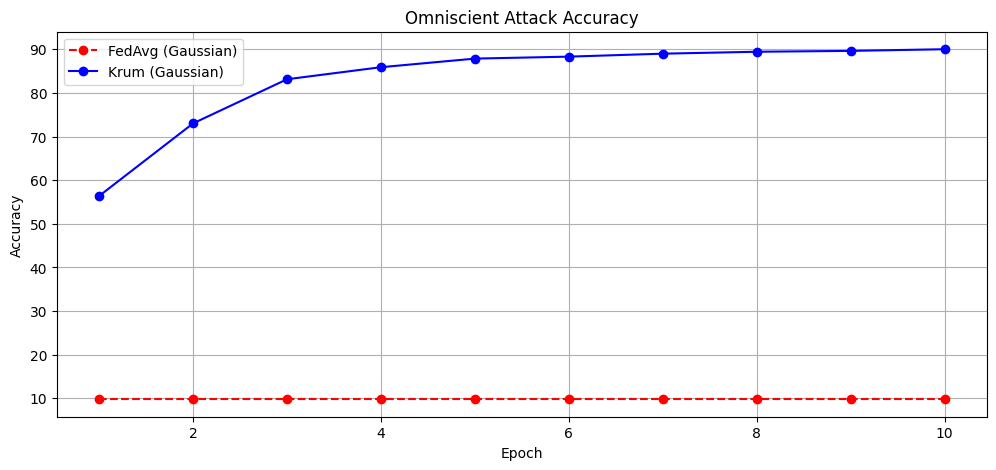

In [13]:
# 绘图对比
plt.figure(figsize=(12, 5))
epochs_range = range(1, len(acc_avg) + 1)
plt.plot(epochs_range, acc_avg, 'r--o', label='FedAvg (Gaussian)')
plt.plot(epochs_range, acc_krum, 'b-o', label='Krum (Gaussian)')
plt.title('Omniscient Attack Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
print("\n--- 实验 3: FedAvg (高斯攻击) ---")
loss_avg_gauss, acc_avg_gauss = train_distributed("Avg", attack_type="Gaussian", num_epochs=10, f=3)

print("\n--- 实验 4: Krum (高斯攻击) ---")
loss_krum_gauss, acc_krum_gauss = train_distributed("Krum", attack_type="Gaussian", num_epochs=10, f=3)


--- 实验 3: FedAvg (高斯攻击) ---
开始训练: 聚合方法=Avg, 恶意节点数=3
Epoch 1: Loss=2881.4101, Accuracy=65.88%
Epoch 2: Loss=4384.7960, Accuracy=61.92%
Epoch 3: Loss=1532.4289, Accuracy=16.75%
Epoch 4: Loss=701.8603, Accuracy=10.16%
Epoch 5: Loss=519.1920, Accuracy=9.30%
Epoch 6: Loss=538.9838, Accuracy=9.13%
Epoch 7: Loss=496.4631, Accuracy=9.77%
Epoch 8: Loss=556.6013, Accuracy=10.02%
Epoch 9: Loss=578.6868, Accuracy=9.79%
Epoch 10: Loss=570.4662, Accuracy=9.75%

--- 实验 4: Krum (高斯攻击) ---
开始训练: 聚合方法=Krum, 恶意节点数=3
Epoch 1: Loss=2.1430, Accuracy=52.54%
Epoch 2: Loss=1.5612, Accuracy=76.36%
Epoch 3: Loss=0.9449, Accuracy=81.17%
Epoch 4: Loss=0.6691, Accuracy=85.26%
Epoch 5: Loss=0.5439, Accuracy=86.83%
Epoch 6: Loss=0.4726, Accuracy=88.01%
Epoch 7: Loss=0.4259, Accuracy=88.81%
Epoch 8: Loss=0.3979, Accuracy=89.38%
Epoch 9: Loss=0.3778, Accuracy=89.84%
Epoch 10: Loss=0.3599, Accuracy=89.95%


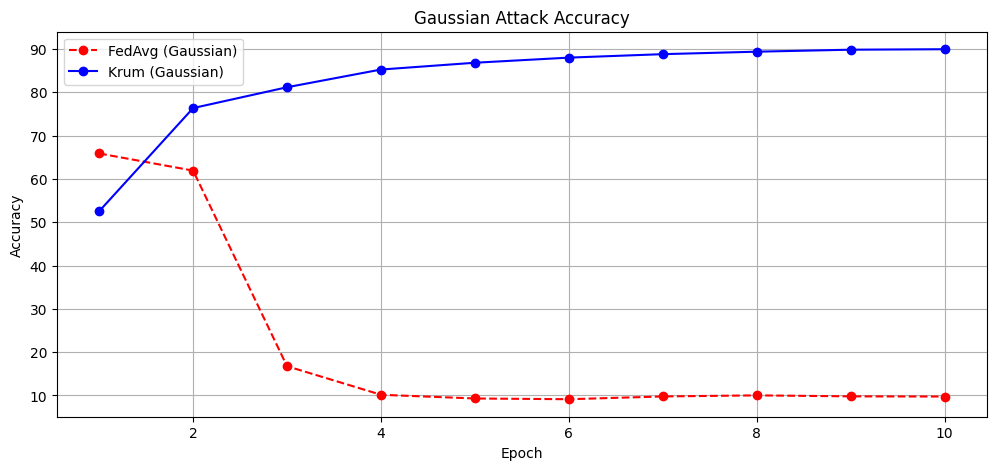

In [29]:
# 绘图对比
plt.figure(figsize=(12, 5))
epochs_range = range(1, len(acc_avg_gauss) + 1)
plt.plot(epochs_range, acc_avg_gauss, 'r--o', label='FedAvg (Gaussian)')
plt.plot(epochs_range, acc_krum_gauss, 'b-o', label='Krum (Gaussian)')
plt.title('Gaussian Attack Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 6. 对比 Muti_krum 和 krum 的区别

--- 实验 5: Krum (全知攻击) ---
开始训练: 聚合方法=Krum, 恶意节点数=3
Epoch 1: Loss=2.1914, Accuracy=56.71%
Epoch 2: Loss=1.6705, Accuracy=75.10%
Epoch 3: Loss=0.9882, Accuracy=80.79%
Epoch 4: Loss=0.6736, Accuracy=83.99%
Epoch 5: Loss=0.5463, Accuracy=86.16%
Epoch 6: Loss=0.4740, Accuracy=87.57%
Epoch 7: Loss=0.4297, Accuracy=88.42%
Epoch 8: Loss=0.4008, Accuracy=89.03%
Epoch 9: Loss=0.3769, Accuracy=89.33%
Epoch 10: Loss=0.3618, Accuracy=89.90%

--- 实验 6: Multi-Krum (全知攻击) ---
开始训练: 聚合方法=Multi-Krum, 恶意节点数=3
Epoch 1: Loss=2.1431, Accuracy=60.66%
Epoch 2: Loss=1.5849, Accuracy=76.90%
Epoch 3: Loss=0.9460, Accuracy=83.73%
Epoch 4: Loss=0.6536, Accuracy=86.27%
Epoch 5: Loss=0.5256, Accuracy=87.88%
Epoch 6: Loss=0.4556, Accuracy=88.87%
Epoch 7: Loss=0.4115, Accuracy=89.47%
Epoch 8: Loss=0.3819, Accuracy=89.97%
Epoch 9: Loss=0.3618, Accuracy=90.30%
Epoch 10: Loss=0.3447, Accuracy=90.57%


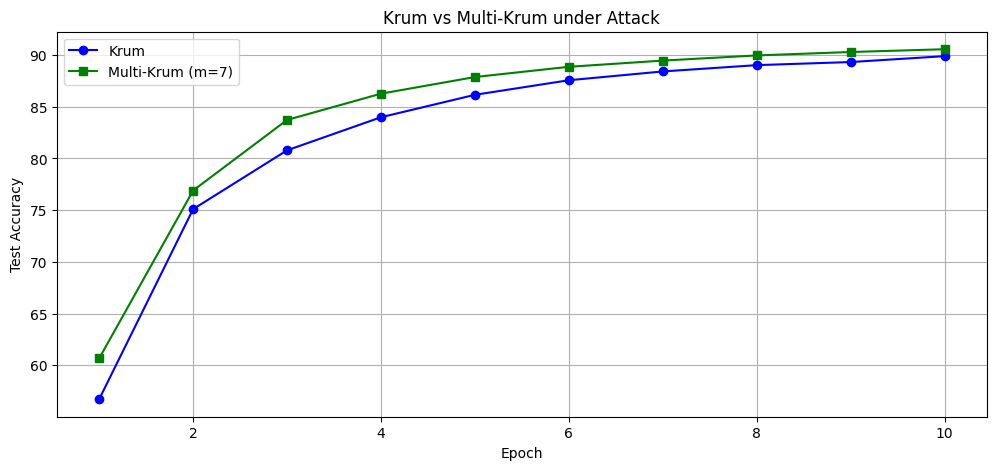

In [30]:
# 运行对比实验 (全知攻击下)
print("--- 实验 5: Krum (全知攻击) ---")
loss_krum, acc_krum = train_distributed("Krum", attack_type="Omniscient", num_epochs=10, f=3)

print("\n--- 实验 6: Multi-Krum (全知攻击) ---")
loss_multi, acc_multi = train_distributed("Multi-Krum", attack_type="Omniscient", num_epochs=10, f=3)

# 绘图对比
plt.figure(figsize=(12, 5))
epochs_range = range(1, len(acc_krum) + 1)
plt.plot(epochs_range, acc_krum, 'b-o', label='Krum')
plt.plot(epochs_range, acc_multi, 'g-s', label='Multi-Krum (m=7)')
plt.title('Krum vs Multi-Krum under Attack')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 7. 在没有拜占庭节点下 krum 算法的影响

In [31]:
def train_distributed_clean(aggregation_method, num_epochs=5, f_defense=3):
    """
    基于简化版逻辑（每个batch迭代一次）的无攻击训练函数。
    用于对比 Clean 环境下各算法的性能。
    """
    model = MLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    history_loss = []
    history_acc = []
    
    print(f"\n开始无攻击训练: 聚合={aggregation_method}, 防御参数 f={f_defense}")
    
    steps_per_epoch = len(train_loaders[0])
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        iterators = [iter(loader) for loader in train_loaders]
        
        for _ in range(steps_per_epoch):
            collected_gradients = []
            
            # A. 遍历所有 Worker (全员诚实)
            for worker_id in range(NUM_WORKERS):
                try:
                    data, target = next(iterators[worker_id])
                except StopIteration:
                    iterators[worker_id] = iter(train_loaders[worker_id])
                    data, target = next(iterators[worker_id])
                
                data, target = data.to(device), target.to(device)
                
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                
                # 获取梯度
                flat_grad = get_flat_grad(model)
                collected_gradients.append(flat_grad)
            
            # B. 聚合 (只防御，不攻击)
            if aggregation_method == "Avg":
                global_grad = average_aggregation(collected_gradients)
            elif aggregation_method == "Krum":
                global_grad = krum_aggregation(collected_gradients, f_defense)
            elif aggregation_method == "Multi-Krum":
                # Multi-Krum 保留 n - f 个
                global_grad = multi_krum_aggregation(collected_gradients, f_defense, m=(NUM_WORKERS - f_defense))
            
            # C. 更新全局模型
            optimizer.zero_grad()
            apply_flat_grad(model, global_grad)
            optimizer.step()
            
            epoch_loss += loss.item()
            
        # 评估
        avg_loss = epoch_loss / steps_per_epoch
        history_loss.append(avg_loss)
        
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        acc = 100. * correct / len(test_loader.dataset)
        history_acc.append(acc)
        model.train()
        
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={acc:.2f}%")
        
    return history_loss, history_acc


In [32]:
# --- 执行对比实验 ---
# 1. FedAvg (Clean Baseline)
_, acc_simple_clean_avg = train_distributed_clean("Avg", num_epochs=10, f_defense=0)

# 2. Krum (Clean, f=3)
_, acc_simple_clean_krum = train_distributed_clean("Krum", num_epochs=10, f_defense=3)

# 3. Multi-Krum (Clean, f=3)
_, acc_simple_clean_multi = train_distributed_clean("Multi-Krum", num_epochs=10, f_defense=3)


开始无攻击训练: 聚合=Avg, 防御参数 f=0
Epoch 1: Loss=2.1407, Accuracy=70.08%
Epoch 2: Loss=1.4962, Accuracy=80.79%
Epoch 3: Loss=0.8516, Accuracy=84.85%
Epoch 4: Loss=0.6005, Accuracy=87.04%
Epoch 5: Loss=0.4928, Accuracy=88.18%
Epoch 6: Loss=0.4364, Accuracy=89.03%
Epoch 7: Loss=0.3989, Accuracy=89.65%
Epoch 8: Loss=0.3732, Accuracy=90.07%
Epoch 9: Loss=0.3537, Accuracy=90.37%
Epoch 10: Loss=0.3393, Accuracy=90.67%

开始无攻击训练: 聚合=Krum, 防御参数 f=3
Epoch 1: Loss=2.1846, Accuracy=57.72%
Epoch 2: Loss=1.6488, Accuracy=72.50%
Epoch 3: Loss=0.9708, Accuracy=80.78%
Epoch 4: Loss=0.6690, Accuracy=85.19%
Epoch 5: Loss=0.5374, Accuracy=86.77%
Epoch 6: Loss=0.4659, Accuracy=87.72%
Epoch 7: Loss=0.4241, Accuracy=88.60%
Epoch 8: Loss=0.3953, Accuracy=89.24%
Epoch 9: Loss=0.3736, Accuracy=89.47%
Epoch 10: Loss=0.3578, Accuracy=89.90%

开始无攻击训练: 聚合=Multi-Krum, 防御参数 f=3
Epoch 1: Loss=2.1965, Accuracy=56.66%
Epoch 2: Loss=1.6797, Accuracy=72.84%
Epoch 3: Loss=1.0057, Accuracy=82.33%
Epoch 4: Loss=0.6795, Accuracy=85.9

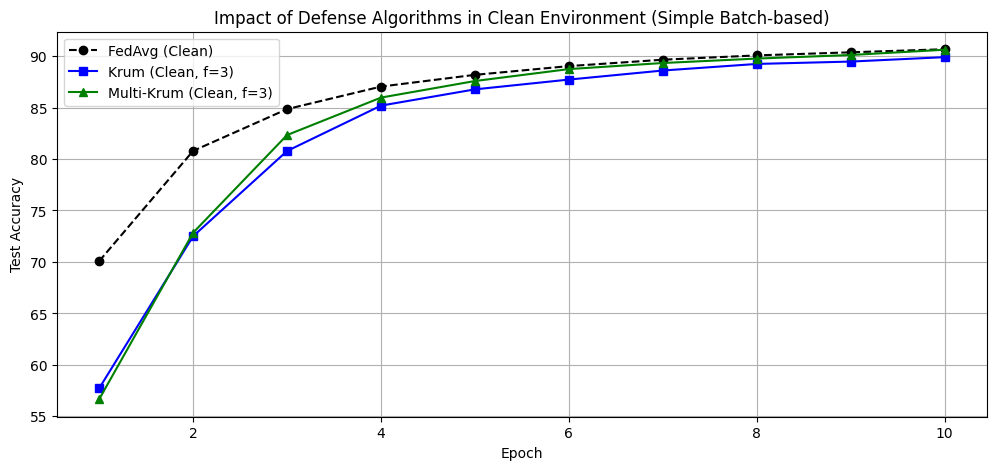

In [33]:
# 4. 绘图
plt.figure(figsize=(12, 5))
epochs_range = range(1, len(acc_simple_clean_avg) + 1)
plt.plot(epochs_range, acc_simple_clean_avg, 'k--o', label='FedAvg (Clean)')
plt.plot(epochs_range, acc_simple_clean_krum, 'b-s', label='Krum (Clean, f=3)')
plt.plot(epochs_range, acc_simple_clean_multi, 'g-^', label='Multi-Krum (Clean, f=3)')
plt.title('Impact of Defense Algorithms in Clean Environment (Simple Batch-based)')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()